In [1]:
using Pkg
Pkg.instantiate()
using GoldGates
using MSSim: Optimizers as Opts, SegSeq as SS, SymLinear as SL, Sequence as Seq, Utils as U

In [2]:
using BenchmarkTools
using NLopt
using Statistics
using PyPlot
using JSON
ENV["MPLBACKEND"] = "module://matplotlib_inline.backend_inline"

"module://matplotlib_inline.backend_inline"

In [3]:
# Load in system parameters - Participation factors and mode frequencies
sysparams = open("../system params/072125_goldparams_13ions.json") do io
    read(io, GoldGates.SystemParams; format=:json)
end;

In [4]:
# Constants across notebook
const nions = 13

# Objective function for optimization
function _objfunc(vals)
    dis = vals[1]
    disδ = vals[2]
    area = vals[3]
    areaδ = vals[4]
    τ = vals[5]

    return 5 * dis + disδ / 100 + (abs(area) - π / 2)^2 * 100 + (areaδ / 1e4)^2
end
const objfunc = Opts.autodiff(_objfunc);

Function for Generating one gate pair and printing results:

In [5]:
function gen_gate(
    ion1,  # Ion 1 and 2 in gate pair, counted in chain from left to right starting at 1
    ion2, 
    min_τ, # min and max gate time (τ)
    max_τ, 
    min_Ω, # min and max rabi frequency (Ω)
    max_Ω, 
    min_ω, # min and max drive frequencies (ω)
    max_ω, 
    blackman_ratio=0.7, # ratio of the amplitude profile where the amplitude is at max
    nseg = 120, # number of segments for the gate
    niter = 150, # number of iterations of optimization
    )
    # Construct modes matrix using system parameters
    modes = Seq.Modes()
    for i in 1:13
        push!(modes, 2π * sysparams.modes.radial1[i], sysparams.participation_factors[i][ion1] * sysparams.participation_factors[i][ion2] * sysparams.lamb_dicke_parameters[i]^2)
    end

    # Define amplitude profile as blackman pulse
    blackman_start_end = U.BlackmanStartEnd{blackman_ratio}()

    # Make plotting and optimization buffers
    buf_opt = SL.ComputeBuffer{nseg,Float64}(Val(SS.mask_allδ), Val(SS.mask_allδ));
    buf_plot = SL.ComputeBuffer{nseg,Float64}(Val(SS.mask_full), Val(SS.mask_full));

    # Nonlinear optimization model using objective function
    nlmodel = Seq.Objective(SL.pmask_full,
                              ((:dis2, 0), (:disδ2, 0), (:area, 0),
                               (:areaδ, 0), (:τ, 0)),
                              objfunc, modes, buf_opt,
                              freq=Seq.FreqSpec(true, sym=false),
                              amp=Seq.AmpSpec(cb=blackman_start_end));
    nargs = Seq.nparams(nlmodel)
    tracker = Opts.NLVarTracker(nargs)

    # Set bounds for optimizer
    Opts.set_bound!(tracker, nlmodel.param.τ, min_τ, max_τ)
    Opts.set_bound!(tracker, nlmodel.param.Ωs[1], min_Ω, max_Ω)
    for ω in nlmodel.param.ωs
        Opts.set_bound!(tracker, ω, min_ω, max_ω)
    end

    opt = NLopt.Opt(:LD_LBFGS, nargs)
    NLopt.min_objective!(opt, nlmodel)
    NLopt.lower_bounds!(opt, Opts.lower_bounds(tracker))
    NLopt.upper_bounds!(opt, Opts.upper_bounds(tracker))
    NLopt.maxtime!(opt, 10)

    # optimize for gate (keep track of best)
    best_obj = Inf
    best_params = nothing
    last_ret = nothing
    for i in 1:niter
        obj, params, ret = NLopt.optimize(opt, Opts.init_vars!(tracker))
        last_ret = ret
        # skip failed runs (negative ret code)
        if getfield(NLopt, ret) < 0
            continue
        end
        if obj < best_obj && params !== nothing
            best_obj = obj
            best_params = params
        end
    end

    # Try one last time with previous best initial guess if we have none
    if best_params === nothing
        # attempt a deterministic initialization: use middle of bounds where possible
        init = Opts.init_vars!(tracker)
        obj, params, ret = NLopt.optimize(opt, init)
        if getfield(NLopt, ret) < 0 || params === nothing
            error("gen_gate: optimizer failed to find feasible parameters after $(niter) iterations. Increase niter, increase NLopt.maxtime!, or loosen bounds.")
        end
        best_params = params
        best_obj = obj
    end

    # Build plotting kernel for callers to compute totals/areas
    kern = SL.Kernel(buf_plot, Val(SL.pmask_full));
    return Seq.RawParams(nlmodel, best_params), kern, modes
end

gen_gate (generic function with 4 methods)

### All optimization parameters can be updated here:

In [6]:
# Utility functions
pitime_to_Ω(time) = π / (2 * time)
idx_to_chain_position(ion_idx) = ion_idx - (nions + 1) ÷ 2 # For example, ion 7 -> pos 0 or ion 5 -> pos -2
chain_position_to_idx(ion_pos) = ion_pos + (nions + 1) ÷ 2 # For example, pos 0 -> ion 7 or pos -2 -> ion 5

chain_position_to_idx (generic function with 1 method)

In [ ]:
# Define a set of parameter sets.
# Each dict represents one gate to be generated
param_sets = [
    Dict(
        :ion1 => chain_position_to_idx(-2), :ion2 => chain_position_to_idx(2),
        :min_τ => 0.1, :max_τ => 3,
        :min_Ω => pitime_to_Ω(8), :max_Ω => pitime_to_Ω(3.8),
        :min_ω => 2π * sysparams.modes.radial1[2], :max_ω => 2π * sysparams.modes.radial1[6],
        :blackman_ratio => 0.7, :nseg => 120, :niter => 150
    ),
    # Dict(
    #     :ion1 => chain_position_to_idx(-1), :ion2 => chain_position_to_idx(1),
    #     :min_τ => 0.1, :max_τ => 2.5,
    #     :min_Ω => pitime_to_Ω(8), :max_Ω => pitime_to_Ω(3.8),
    #     :min_ω => 2π * sysparams.modes.radial1[2], :max_ω => 2π * sysparams.modes.radial1[11],
    #     :blackman_ratio => 0.7, :nseg => 120, :niter => 150
    # )
    # Add more sets here if needed
]
# Containers for outputs
solution_dict = Dict()
results = Dict()
# Iterate over each parameter set and call the function
for params in param_sets
    ion1 = params[:ion1]
    ion2 = params[:ion2]
    min_τ = params[:min_τ]
    max_τ = params[:max_τ]
    min_Ω = params[:min_Ω]
    max_Ω = params[:max_Ω]
    min_ω = params[:min_ω]
    max_ω = params[:max_ω]
    blackman_ratio = params[:blackman_ratio]
    nseg = params[:nseg]
    niter = params[:niter]
    pos1 = idx_to_chain_position(ion1)
    pos2 = idx_to_chain_position(ion2)
    key = "$(max(pos1, pos2)),$(min(pos1,pos2))"
    
    println("------------")
    println("Calling gen_gate with parameters for $key:")
    println("   ion1 = $ion1, ion2 = $ion2, min_τ = $min_τ, max_τ = $max_τ")
    println("   min_Ω = $min_Ω, max_Ω = $max_Ω, min_ω = $min_ω, max_ω = $max_ω")
    println("   blackman_ratio = $blackman_ratio, nseg = $nseg, niter = $niter")
    
    # Run optimization and collect outputs
    opt_raw_params, kern, modes = gen_gate(ion1, ion2, min_τ, max_τ, min_Ω, max_Ω, min_ω, max_ω, blackman_ratio, nseg, niter)
    
    # Calculate metadata
    enclosed_area = Seq.total_area(kern, opt_raw_params, modes)
    metadata = Dict(
        "total_gate_time" =>  sum(@view opt_raw_params.args[1:5:end]),
        "total_displacement" =>  Seq.total_dis(kern, opt_raw_params, modes),
        "total_cumulative_displacement" => Seq.total_cumdis(kern, opt_raw_params, modes),
        "gradient_displacement_detuning" => Seq.total_disδ(kern, opt_raw_params, modes),
        "enclosed_area" => enclosed_area,
        "gradient_area_detuning" => Seq.total_areaδ(kern, opt_raw_params, modes),
        "carrier_pi_time_required" => π / maximum(abs.(@view opt_raw_params.args[2:5:end])) / 2,
    )
    println(JSON.json(metadata, 4))
    solution_dict[key] = GoldGates.XXSolution(opt_raw_params, enclosed_area, metadata=JSON.json(metadata))
    results[key] = (opt_raw_params, kern, modes, enclosed_area)
    println("------------")
end

------------

In [ ]:
# Save the generated solutions
output_filename = "../out/20251202_pm_13.json"
solution_set = GoldGates.GateSolutionSet(params=sysparams, XX=solution_dict)
open(output_filename, "w") do io
    write(io, solution_set, format=:json)
end

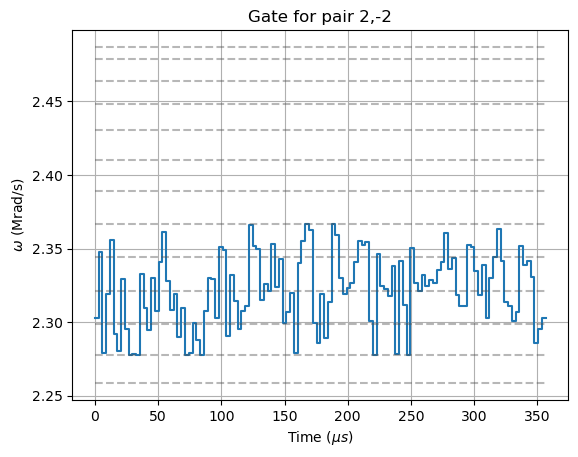

In [ ]:
# Plot each stored solution (drive frequency vs time with mode lines)
for (key, (opt_raw_params, kern, modes, enclosed_area)) in results
    figure()
    ts, ωs = Seq.get_ωs(opt_raw_params)
    plot(ts, ωs ./ 2π)
    title("Gate for pair $key")
    xmin = minimum(ts)
    xmax = maximum(ts)
    # Add horizontal lines for modes for plot
    for (i,f) in enumerate(sysparams.modes.radial1)
        plot([xmin, xmax], [f, f], linestyle="--", color="0.3", alpha=0.4)
    end
    xlabel(raw"Time ($\mu s$)")
    ylabel(raw"$\omega$ (Mrad/s)")
    grid()
end

In [ ]:
for (key, (opt_raw_params, kern, modes, enclosed_area)) in results
    total_time = sum(@view opt_raw_params.args[1:5:end])
    println(total_time)
end

356.5243768475895
